In [40]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)


In [41]:
source('milo_cellbender.R')

In [42]:
obj_neuron = qs::qread('_targets/objects/exp_labelled_neuron') %>%
    set_labels_to_class %>%
    set_batch_to_lane %>%
    prep_obj_for_milo_cb_v01

In [43]:
obj_neuron

An object of class Seurat 
29114 features across 104287 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



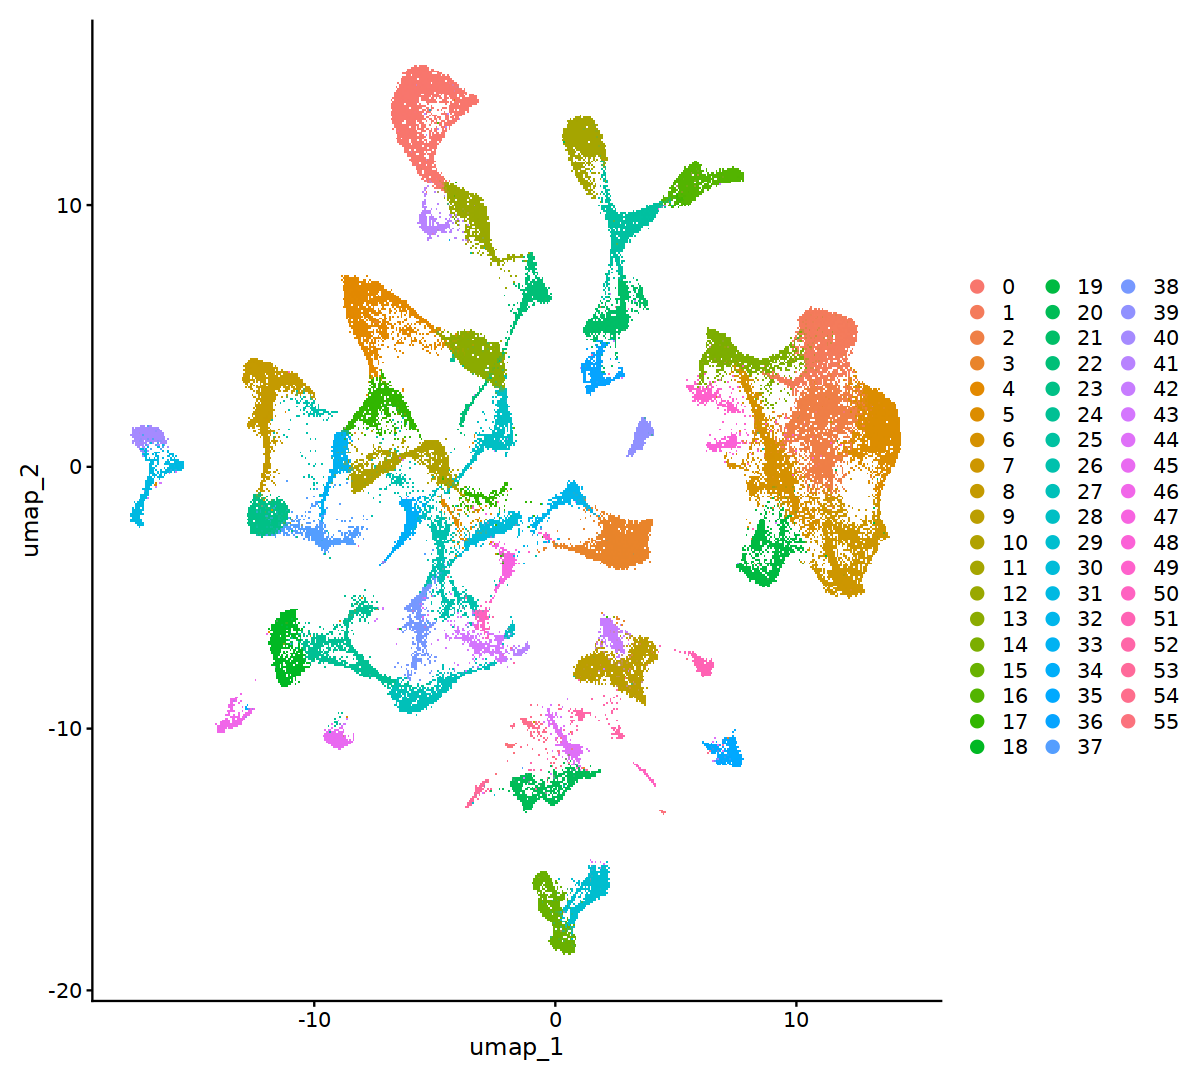

In [44]:
options(repr.plot.width=10, repr.plot.height=9)
DimPlot(obj_neuron)

In [45]:
obj_other = qs::qread('_targets/objects/exp_labelled_other') %>%
    set_labels_to_class %>%
    set_batch_to_lane %>%
    prep_obj_for_milo_cb_v01
obj_other

An object of class Seurat 
25126 features across 32123 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

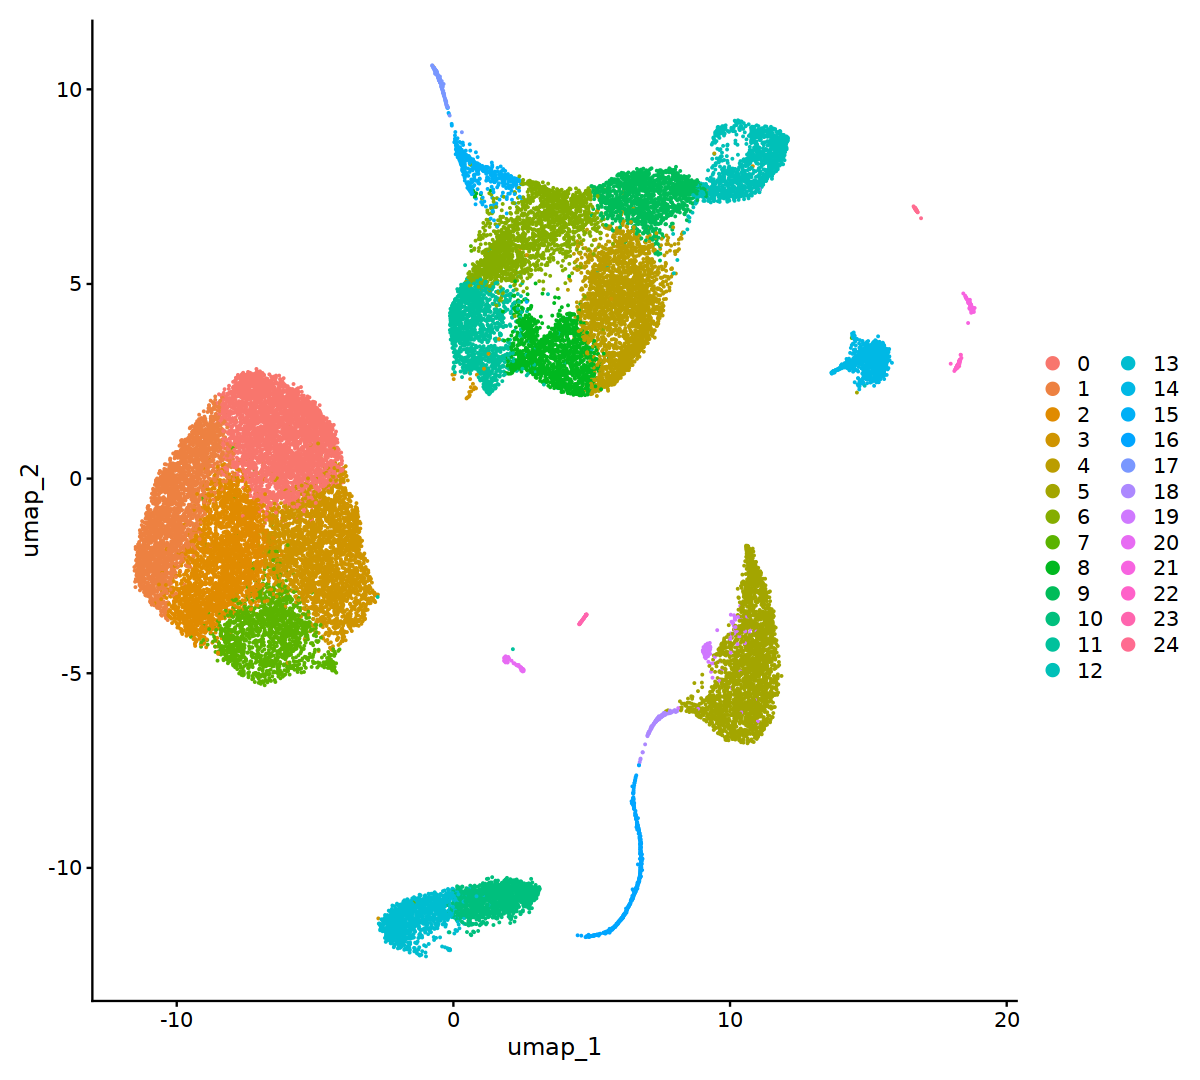

In [46]:
options(repr.plot.width=10, repr.plot.height=9)
DimPlot(obj_other)

In [47]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))
# mutate(class = case_when(labels == 'neuron' ~ 'neuron',
#                          labels == 'other' ~ 'other'))

labels_classes_tib

labels,class
<chr>,<chr>
other,other
neuron,neuron


In [48]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head
umap_coords_neuron %>% dim

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,-0.4342604,6.7461303
2,SI-TT-A11_AAACCCACATACAGCT,-7.3557797,0.3961086
3,SI-TT-A11_AAACCCAGTACGTTCA,-3.4404069,13.9351299
4,SI-TT-A11_AAACCCATCCAAGCAT,7.7133249,-11.4160797
5,SI-TT-A11_AAACCCATCCCATAAG,9.1929654,0.2343295
6,SI-TT-A11_AAACCCATCGTCCTCA,-9.1682301,0.5945974


[1] 104287      3

In [49]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head
umap_coords_other %>% dim

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,1.1562370,5.542229
2,SI-TT-A11_AAACGAAAGCAACAAT,11.2556751,-5.995077
3,SI-TT-A11_AAACGAAAGGTTCTTG,-0.3533742,-10.934463
4,SI-TT-A11_AAACGAACAAGGAGTC,-7.9621904,-3.315451
5,SI-TT-A11_AAACGAACAGCCTTCT,-6.9340403,-2.915615
6,SI-TT-A11_AAACGCTAGTGCTAGG,0.9711418,3.148864


[1] 32123     3

In [50]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [51]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 136410      3

In [52]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob14v14__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_Day14.obob14v14__v__Day14.obobBL6d14') %>%
filter(labels %in% c('neuron', 'other'))
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 3212   18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.27981508,8.641077,2.744191e-01,0.6045648,1,1,0.9999378,none,neuron,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,none,none,none,none,SI-TT-E10_AGGGCCTGTTTGTGGT,86
2,0.25524626,9.109560,6.782635e-01,0.4167759,1,2,0.9999378,none,neuron,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,none,none,none,none,SI-TT-C12_CTACGGGAGCATAGGC,135
3,-0.03119955,9.274478,1.062728e-02,0.9185883,1,3,0.9999378,none,neuron,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,none,none,none,none,SI-TT-G10_CATCCACTCTTTGGAG,155
4,0.17529914,8.798883,2.182514e-01,0.6437985,1,4,0.9999378,none,neuron,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,none,none,none,none,SI-TT-F10_AATGAAGGTATTTCTC,103
5,0.00110119,8.773953,1.596377e-05,0.9968389,1,5,0.9999378,none,neuron,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,none,none,none,none,SI-TT-G10_GGGTGTCGTATTGAGA,99
6,-0.16222542,9.131626,2.165564e-01,0.6450843,1,6,0.9999378,none,neuron,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,none,none,none,none,SI-TT-C12_GTCATTTCAAAGGGCT,134


In [53]:
da_results_restored %>% distinct(labels) 

labels
<chr>
neuron
other


In [54]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_Day14.obobBL6d14') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC) %>%
filter(labels %in% c('neuron', 'other'))


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 3212   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,5.379668,9.010469,127.6036,2.991025e-12,6.301441e-09,1354,6.540278e-09,pos,neuron,1,112,SI-TT-E10_AACCTTTAGGCTGTAG
2,6.138530,8.829116,121.9114,5.182106e-12,6.301441e-09,1680,6.540278e-09,pos,neuron,1,95,SI-TT-F10_TAAGTCGAGAACGTGC
3,4.492929,9.497555,116.0067,9.372860e-12,7.598265e-09,2185,7.384445e-09,pos,neuron,1,169,SI-TT-G10_CACCGTTCAATCCTTT
4,4.185213,9.635192,109.2835,1.896978e-11,9.310618e-09,130,9.073225e-09,pos,neuron,1,188,SI-TT-C12_TCCCACAGTGAATGTA
5,5.559039,8.939540,109.1715,1.919957e-11,9.310618e-09,2012,9.073225e-09,pos,neuron,1,108,SI-TT-F10_ACCTGTCAGCGATCGA
6,5.255177,8.802394,107.5135,2.297027e-11,9.310618e-09,1120,9.189041e-09,pos,neuron,1,93,SI-TT-G11_CGCGTGAAGCAAACAT


In [55]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_Day14.obob14v14') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)  %>%
filter(labels %in% c('neuron', 'other'))


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 3212   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,0.27981508,8.641077,2.744191e-01,0.6045648,1,1,0.9999378,none,neuron,1,86,SI-TT-E10_AGGGCCTGTTTGTGGT
2,0.25524626,9.109560,6.782635e-01,0.4167759,1,2,0.9999378,none,neuron,1,135,SI-TT-C12_CTACGGGAGCATAGGC
3,-0.03119955,9.274478,1.062728e-02,0.9185883,1,3,0.9999378,none,neuron,1,155,SI-TT-G10_CATCCACTCTTTGGAG
4,0.17529914,8.798883,2.182514e-01,0.6437985,1,4,0.9999378,none,neuron,1,103,SI-TT-F10_AATGAAGGTATTTCTC
5,0.00110119,8.773953,1.596377e-05,0.9968389,1,5,0.9999378,none,neuron,1,99,SI-TT-G10_GGGTGTCGTATTGAGA
6,-0.16222542,9.131626,2.165564e-01,0.6450843,1,6,0.9999378,none,neuron,1,134,SI-TT-C12_GTCATTTCAAAGGGCT


In [56]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,0.27981508,8.641077,2.744191e-01,0.6045648,1,1,0.9999378,none,neuron,1,⋯,-0.15515477,8.641077,0.050000008,0.8247104,0.9712812,0.9704757,none,1,86,SI-TT-E10_AGGGCCTGTTTGTGGT
2,0.25524626,9.109560,6.782635e-01,0.4167759,1,2,0.9999378,none,neuron,1,⋯,-0.15402396,9.109560,0.148892325,0.7405246,0.9662765,0.9623682,none,1,135,SI-TT-C12_CTACGGGAGCATAGGC
3,-0.03119955,9.274478,1.062728e-02,0.9185883,1,3,0.9999378,none,neuron,1,⋯,-0.31637054,9.274478,0.643795430,0.4287391,0.8841966,0.8721278,none,1,155,SI-TT-G10_CATCCACTCTTTGGAG
4,0.17529914,8.798883,2.182514e-01,0.6437985,1,4,0.9999378,none,neuron,1,⋯,-0.25273259,8.798883,0.251651898,0.6196276,0.9477574,0.9415909,none,1,103,SI-TT-F10_AATGAAGGTATTTCTC
5,0.00110119,8.773953,1.596377e-05,0.9968389,1,5,0.9999378,none,neuron,1,⋯,-0.06270423,8.773953,0.018747929,0.8920193,0.9807373,0.9799978,none,1,99,SI-TT-G10_GGGTGTCGTATTGAGA
6,-0.16222542,9.131626,2.165564e-01,0.6450843,1,6,0.9999378,none,neuron,1,⋯,-0.03815200,9.131626,0.008057629,0.9290795,0.9870536,0.9853796,none,1,134,SI-TT-C12_GTCATTTCAAAGGGCT


In [57]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 3212   39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,0.27981508,8.641077,2.744191e-01,0.6045648,1,1,0.9999378,none,neuron,1,⋯,0.050000008,0.8247104,0.9712812,0.9704757,none,1,86,neuron,0.7876495,-17.463294
2,0.25524626,9.109560,6.782635e-01,0.4167759,1,2,0.9999378,none,neuron,1,⋯,0.148892325,0.7405246,0.9662765,0.9623682,none,1,135,neuron,-1.9770406,2.035124
3,-0.03119955,9.274478,1.062728e-02,0.9185883,1,3,0.9999378,none,neuron,1,⋯,0.643795430,0.4287391,0.8841966,0.8721278,none,1,155,neuron,-5.4946376,-8.863008
4,0.17529914,8.798883,2.182514e-01,0.6437985,1,4,0.9999378,none,neuron,1,⋯,0.251651898,0.6196276,0.9477574,0.9415909,none,1,103,neuron,-1.2671361,6.293964
5,0.00110119,8.773953,1.596377e-05,0.9968389,1,5,0.9999378,none,neuron,1,⋯,0.018747929,0.8920193,0.9807373,0.9799978,none,1,99,neuron,-9.5487300,-1.127961
6,-0.16222542,9.131626,2.165564e-01,0.6450843,1,6,0.9999378,none,neuron,1,⋯,0.008057629,0.9290795,0.9870536,0.9853796,none,1,134,neuron,3.6163956,-8.814124


In [58]:
da_results %>% group_by(class) %>% summarise(n = n())

class,n
<chr>,<int>
neuron,2432
other,780


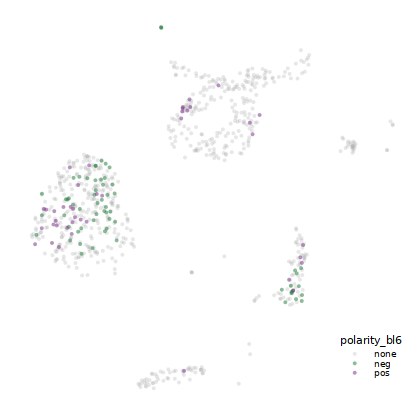

In [59]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

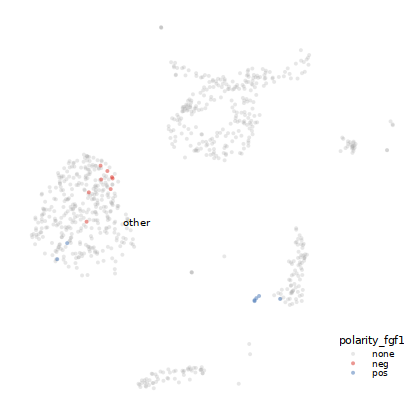

In [60]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

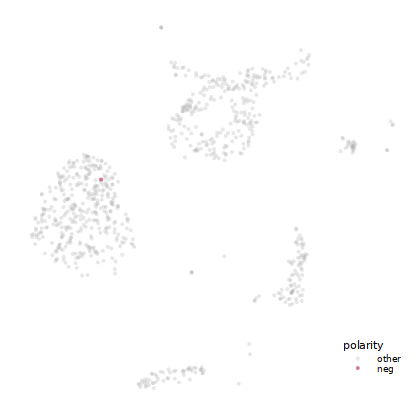

In [61]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [62]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'Day14.obob14v14__v__Day14.obobBL6d14') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
g3,86,18,9,9,0.5000000,0,0,0,0,NaN,0.00000000,Day14.obob14v14__v__Day14.obobBL6d14,0.20930233,0.00000000,0.2093023,18
other,780,15,7,8,0.4666667,102,1,0,1,0.009803922,0.06666667,Day14.obob14v14__v__Day14.obobBL6d14,0.01923077,0.13076923,0.1500000,117
g2,285,13,9,4,0.6923077,105,4,2,2,0.038095238,0.30769231,Day14.obob14v14__v__Day14.obobBL6d14,0.04561404,0.36842105,0.4140351,118
OPC,66,8,4,4,0.5000000,0,0,0,0,NaN,0.00000000,Day14.obob14v14__v__Day14.obobBL6d14,0.12121212,0.00000000,0.1212121,8
Met__Pappa2,17,3,3,NA,1.0000000,0,0,0,0,NaN,0.00000000,Day14.obob14v14__v__Day14.obobBL6d14,0.17647059,0.00000000,0.1764706,3
Oligodendrocytes,79,3,3,NA,1.0000000,6,0,0,0,0.000000000,0.00000000,Day14.obob14v14__v__Day14.obobBL6d14,0.03797468,0.07594937,0.1139241,9


[1] "g3"                  "other"               "g2"                 
 [4] "OPC"                 "Met__Pappa2"         "Oligodendrocytes"   
 [7] "n2"                  "Agrp"                "Arx__Nr5a2"         
[10] "Astrocytes"          "Dlk1"                "Ependymal_cells"    
[13] "Esr1"                "Fez1"                "Ghrh"               
[16] "Gpr50__Tac2"         "Hdc"                 "Htr3b"              
[19] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Lepr15"             
[22] "Lepr67"              "Lepr89"              "Lpar1_oligo"        
[25] "Met__Prlh"           "Microglia"           "Nfib_1"             
[28] "Nfib_2"              "Nfib_3"              "Nfix__Nfib"         
[31] "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"    "Npsr1__Epha3"       
[34] "Pomc__Anxa2"         "Pomc__Glipr1"        "Pomc__Ttr"          
[37] "Pou6f2__Prkcq__Whrn" "Ppp1r17"             "Ppp1r17__Ltbp1"     
[40] "Ppp1r17__Tafa4"      "Reln__Lef1"          "Sim1"               
[43] "Slc17a6__Trhr"       "Sst__Nts"            "Sst__Pthlh"         
[46] "Sst__Unc13c"         "Tanycytes"           "Tbx19__Pirt"        
[49] "Th__Nfib"            "Th__Slc6a3"          "Tmem215__Dach2"     
[52] "Tmem215__Greb1"      "Trh__Cxcl12"         "Trh__Lef1"          
[55] "g1"                  "g4"                  "n0"                 
[58] "n1"                  "n10"                 "n3"                 
[61] "n4"                  "n5"                  "n7"                 
[64] "n8"                  "n9"                  "n_drop"             
[67] "neuron"

In [63]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,1
other,1
NA,34


In [64]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
neuron,2432,0,NA,NA,NA,178,0,0,0,0,NaN,Day14.obob14v14__v__Day14.obobBL6d14,0,0.07319079,0.07319079,178,neuron


In [65]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Arx__Nr5a2"          "Dlk1"                "Ependymal_cells"    
 [4] "Fez1"                "Gpr50__Tac2"         "Hdc"                
 [7] "Irx5__Lmx1a"         "Lepr15"              "Lepr67"             
[10] "Lepr89"              "Nfib_1"              "Nfib_2"             
[13] "Nfib_3"              "Nfix__Nfib"          "Nfix__Nfib__Hgf"    
[16] "Nfix__Nfib__Lhx6"    "Npsr1__Epha3"        "Pou6f2__Prkcq__Whrn"
[19] "Ppp1r17"             "Ppp1r17__Ltbp1"      "Ppp1r17__Tafa4"     
[22] "Reln__Lef1"          "Sim1"                "Sst__Nts"           
[25] "Trh__Lef1"           "g1"                  "n10"                
[28] "n4"                  "n7"                  "n8"                 
[31] "n_drop"

In [66]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,36,0,NA,NA,NA,17,0,0,0,0,NaN,Day14.obob14v14__v__Day14.obobBL6d14,0,0.4722222,0.4722222,17


In [67]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
333,other,other,80,pos_FGF1,no,FGF1,pos.FGF1,0.007168047,2.28123236,other.FGF1
333,other,other,80,pos_FGF1,no,BL6,none,0.690579733,0.49625354,other.BL6
570,other,other,79,pos_FGF1,no,FGF1,pos.FGF1,0.007168047,2.37790759,other.FGF1
570,other,other,79,pos_FGF1,no,BL6,none,0.624241817,0.58775566,other.BL6
575,other,other,85,pos_FGF1,no,FGF1,pos.FGF1,0.007168047,2.28788423,other.FGF1
575,other,other,85,pos_FGF1,no,BL6,none,0.764108404,0.40396177,other.BL6
484,other,other,62,pos_FGF1,no,FGF1,pos.FGF1,0.040709125,2.19347394,other.FGF1
484,other,other,62,pos_FGF1,no,BL6,none,0.720753917,-0.59518861,other.BL6
3,other,other,272,neg_FGF1,no,FGF1,neg.FGF1,0.040916201,-0.95898323,other.FGF1


In [68]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1   333 other  other      80 pos_FGF1       no       FGF1       pos.FGF1
2   333 other  other      80 pos_FGF1       no       BL6        none    
3   570 other  other      79 pos_FGF1       no       FGF1       pos.FGF1
4   570 other  other      79 pos_FGF1       no       BL6        none    
5   575 other  other      85 pos_FGF1       no       FGF1       pos.FGF1
6   575 other  other      85 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [69]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.FGF1 neg.BL6  pos.BL6 
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [70]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1]  2 11

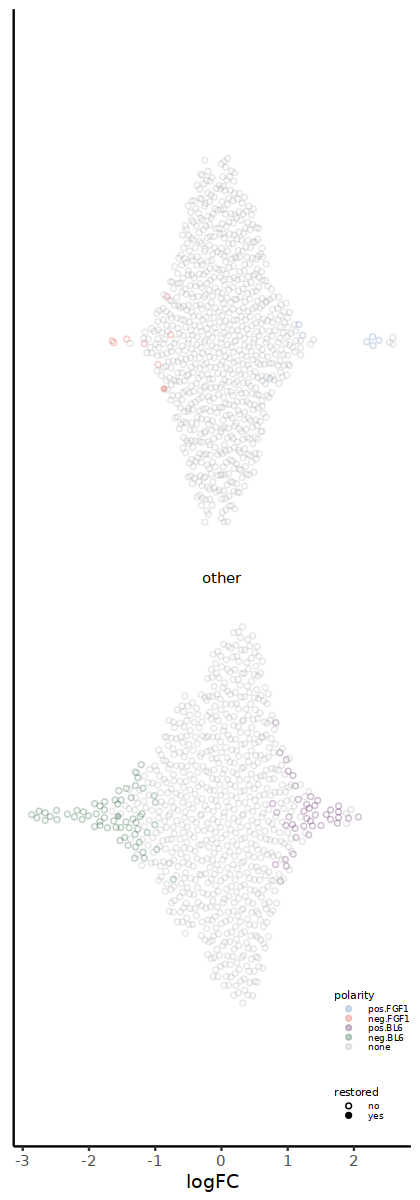

In [71]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

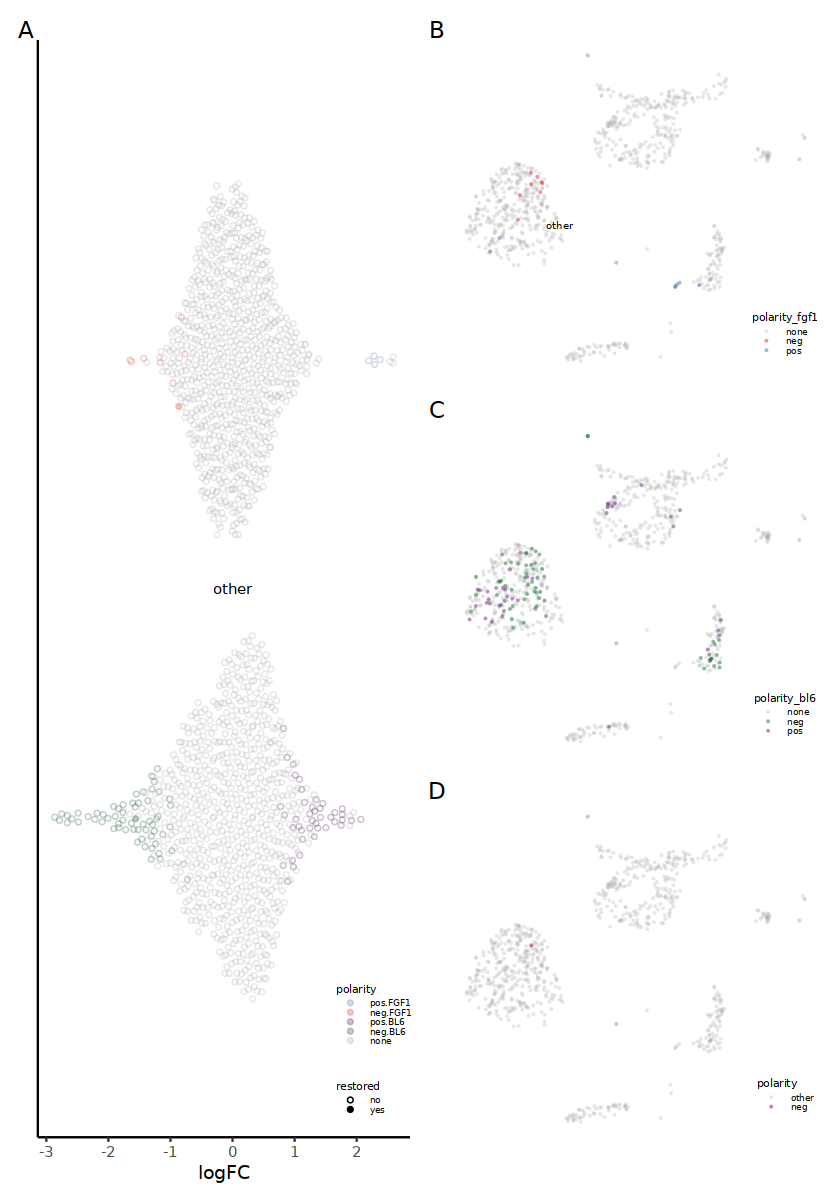

In [72]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_d14_class.pdf', plot = ., width = 7, height=9)
ggp

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 0

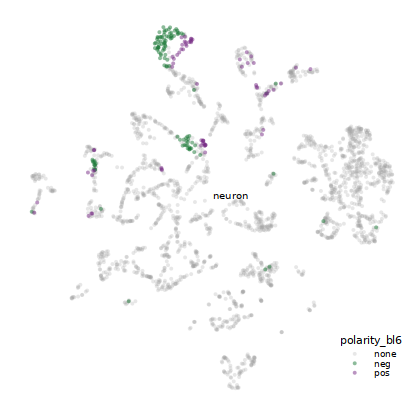

In [73]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 1

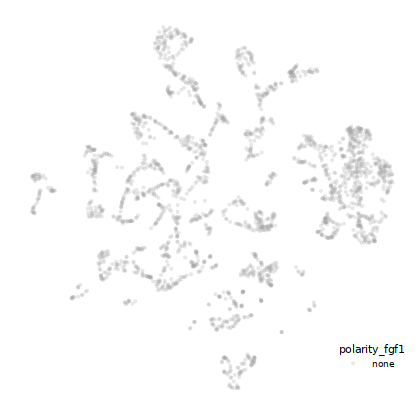

In [74]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

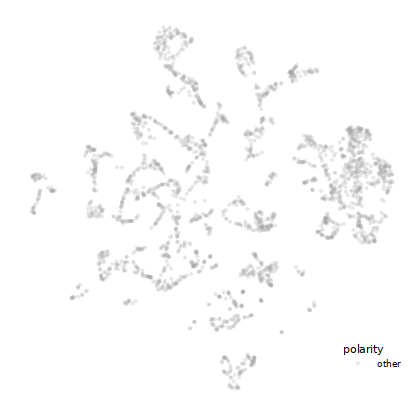

In [75]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

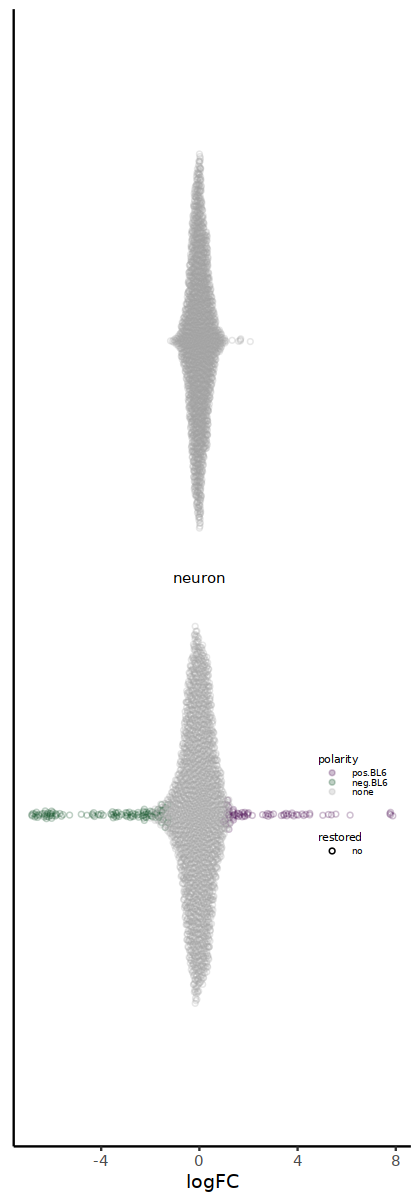

In [76]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

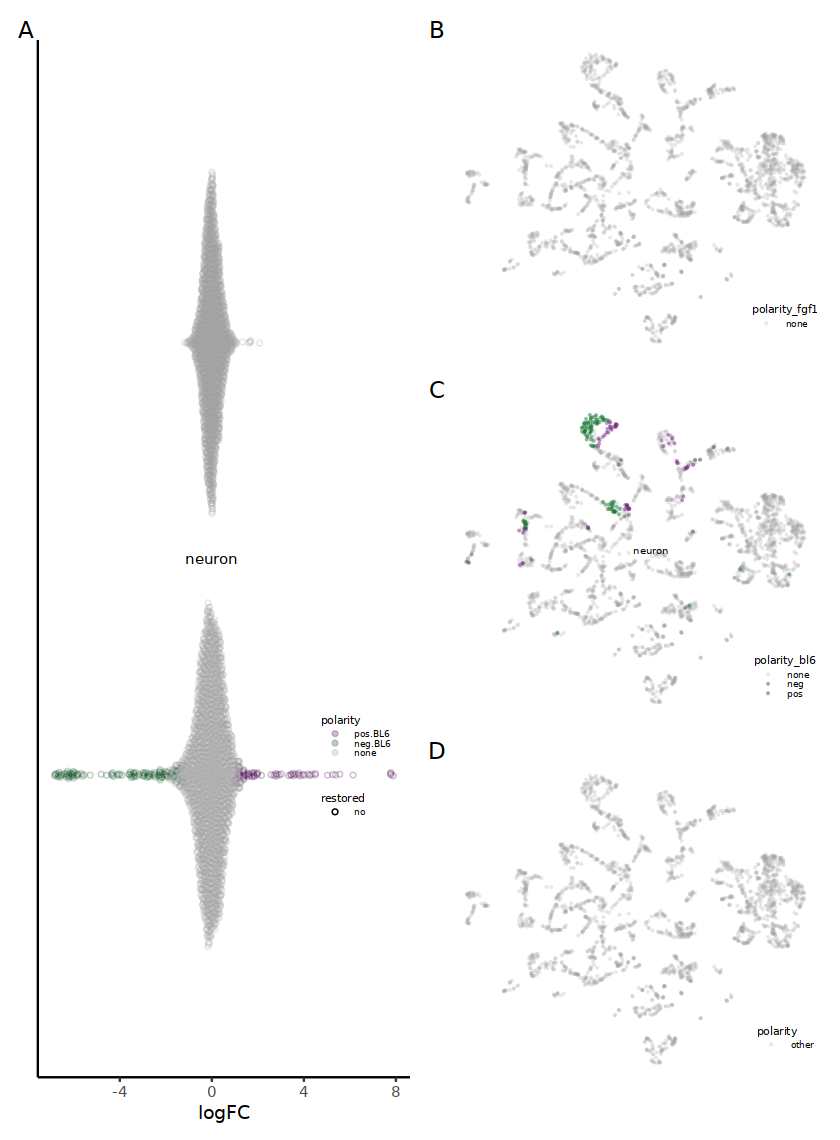

In [77]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_d14_class.pdf', plot = ., width = 7, height=9)
ggp

In [78]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_d14.qs')
da_results %>% qs::qsave('beeswarm_da_results_d14.qs')